In [13]:
%pip install -r python_requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate as intp
import matplotlib.pyplot as plt
import tfs
import json
import toolkit.create_error_table as cet
import toolkit.make_install_bpm_mcb_script as mibms

from cpymad.madx import Madx

In [15]:
# define operation mode and load reference parameter file
OPERATION_MODE='z'
REFERENCE_PARAMETER = json.load(open('./reference_parameters.json'))

In [16]:
# create cpymad instance to load lattice and create twiss as input for error function
with Madx(stdout=False) as mad:

    mad.input('SET, FORMAT="19.15f";')
    filename = Path(f"./lattices/{OPERATION_MODE}/fccee_{OPERATION_MODE}.seq")
    mad.call(str(filename))
    mad.beam(
                particle='electron',
                npart=214000000000.0,
                kbunch=11200,
                pc=45.6,
                radiate=False,
                bv=1,
                ex=7.1e-10,
                ey=1.9e-12)
    mad.use('FCCEE_P_RING')

#     mad.input(
# """SEQEDIT, SEQUENCE = FCCEE_P_RING;
# 		FLATTEN;
# 		CYCLE, START=FRF1.1;
# 		FLATTEN;
# ENDEDIT;""")

    mad.input(
"""VOLTCA1SAVE = VOLTCA1; 
VOLTCA2SAVE = VOLTCA2; 

VOLTCA1 = 0;
VOLTCA2 = 0;""")
    mad.use('FCCEE_P_RING')

    mad.twiss(sequence='FCCEE_P_RING',file=f'twiss_{OPERATION_MODE}.tfs')
    # create MAD-X install file for BPMs and correctors
    mibms.main(
        tfs_file=f'twiss_{OPERATION_MODE}.tfs',
        focussing_quad='^QF[1234]\\..*',
        defocussing_quad='^QD[1234]\\..*',
        output_file='install_bpm_orbitcorrectors.madx'
    )


In [17]:
# load twiss
twiss_df = tfs.read(f'twiss_{OPERATION_MODE}.tfs', index='NAME')

In [18]:
# call error creation routine using loaded twiss as input
error_df = cet.main(
    twiss_df=twiss_df, # twiss file to get list of elements and their location
    errors_dict={'Reference_radius': 0.01, 'Q[FD]\d\..*':{ 'dX_syst':0.000, },}, # regular, uncorrelated alignment and field errors
    longrangealignment_dict={  # dictionary containing parameters for correlated misalignments over given length scales
        'Q[FD]\d\..*':{ # regex expression to select elements to be misaligned, in this case only the arc quadrupoles QF4/QD3
        'X':[  # plane in which alignment acts
            [200, 500e-6], # parameters are given as [length scale in m, sigma for transverse misalignment in m]
            [50, 200e-6],
            [6, 50e-6],
        ],
        'Y':[ 
            [200, 150e-6],
            [50, 50e-6],
            [6, 50e-6],
        ]
        }},
    seed=1,
    full_table=False, # if True, errors for all elements are saved, even those without errors
    gridsize=1.,
)

error_df

Headers:
    NAME: EFIELD
    TYPE: EFIELD
    TITLE: no-title
    ORIGIN: 3.14.15 Linux 128
    DATE: 01/13/00
    TIME: 25.61.61

         K0L  K0SL  K1L  K1SL  K2L  K2SL  K3L  K3SL  K4L  K4SL  ...  K19L   
NAME                                                            ...         
QF4.1    0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...   0.0  \
QD3.1   -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0  ...  -0.0   
QF4.2    0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...   0.0   
QD3.2   -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0  ...  -0.0   
QF4.3    0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...   0.0   
...      ...   ...  ...   ...  ...   ...  ...   ...  ...   ...  ...   ...   
QF2.358  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...   0.0   
QD1.359 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0  ...  -0.0   
QF2.359  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...   0.0   
QD1.360 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0 -0.0  -0.0  ...  -0.0   
QF2.360  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0   0.0  ...   0.0   

         K19SL  K20L  K20SL        DX        DY   DS  DPHI  DTHETA  DPSI  
NAME                                                                      
QF4.1      0.0   0.0    0.0  0.000642  0.000051  0.0   0.0     0.0   0.0  
QD3.1     -0.0  -0.0   -0.0  0.000502  0.000092  0.0   0.0     0.0   0.0  
QF4.2      0.0   0.0    0.0  0.000216 -0.000067  0.0   0.0     0.0   0.0  
QD3.2     -0.0  -0.0   -0.0 -0.000117 -0.000040  0.0   0.0     0.0   0.0  
QF4.3      0.0   0.0    0.0 -0.000643  0.000025  0.0   0.0     0.0   0.0  
...        ...   ...    ...       ...       ...  ...   ...     ...   ...  
QF2.358    0.0   0.0    0.0 -0.000187  0.000112  0.0   0.0     0.0   0.0  
QD1.359   -0.0  -0.0   -0.0 -0.000513 -0.000136  0.0   0.0     0.0   0.0  
QF2.359    0.0   0.0    0.0 -0.000670 -0.000136  0.0   0.0     0.0   0.0  
QD1.360   -0.0  -0.0   -0.0 -0.000778 -0.000036  0.0   0.0     0.0   0.0  
QF2.360    0.0   0.0    0.0 -0.000375  0.000285  0.0   0.0     0.0   0.0  

[1420 rows x 48 columns]

In [19]:
full_grid = pd.read_csv('grid_Q[FD]\d\..*.csv')
full_grid 

Unnamed: 0             S         X         Y
0               0      0.000000 -0.000568 -0.000065
1               1      1.000000 -0.000593 -0.000064
2               2      2.000000 -0.000620 -0.000063
3               3      3.000000 -0.000649 -0.000062
4               4      4.000000 -0.000679 -0.000062
...           ...           ...       ...       ...
90655       90655  90655.000000 -0.000476 -0.000053
90656       90656  90656.000000 -0.000504 -0.000061
90657       90657  90657.000000 -0.000528 -0.000065
90658       90658  90658.000000 -0.000551 -0.000066
90659       90659  90658.745319 -0.000568 -0.000065

[90660 rows x 4 columns]

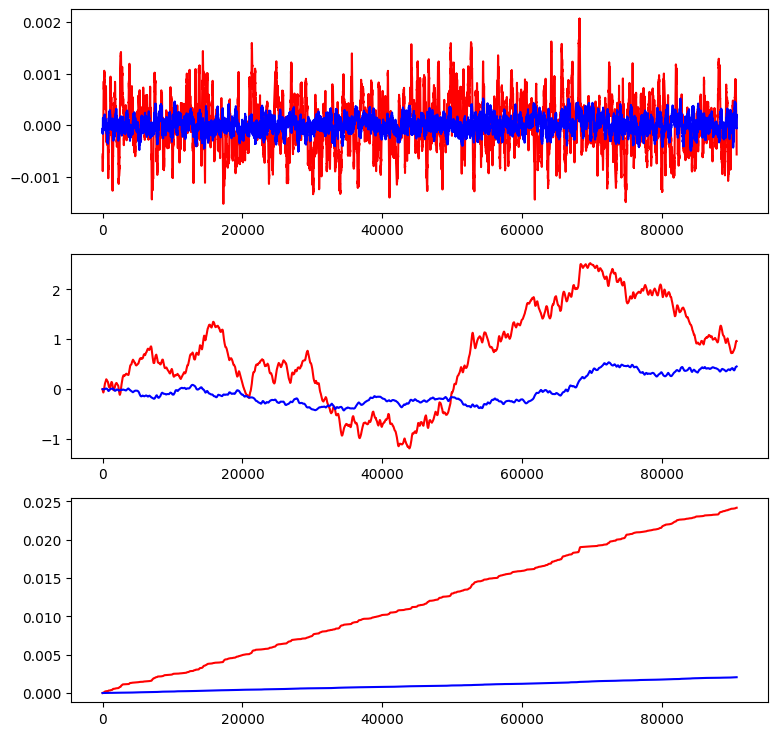

In [20]:
# plot grid 
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(9,9)
)

ax[0].plot(full_grid['S'], full_grid['X'], color='red')
ax[0].plot(full_grid['S'], full_grid['Y'], color='blue')

ax[1].plot(full_grid['S'], np.cumsum(full_grid['X']), color='red')
ax[1].plot(full_grid['S'], np.cumsum(full_grid['Y']), color='blue')

ax[2].plot(full_grid['S'], np.cumsum(np.square(full_grid['X'])), color='red')
ax[2].plot(full_grid['S'], np.cumsum(np.square(full_grid['Y'])), color='blue')


plt.show()

In [21]:
# create three error files with increasing number of errors

cases = {
    'case1': {
        'Q[FD]\d\..*':{
        'X':[
            [200, 500e-6],
        ]
        },
        },
    'case2': {
        'Q[FD]\d\..*':{
        'X':[
            [200, 500e-6],
            [50, 200e-6],
        ]
        },
        },
    'case3': {
        'Q[FD]\d\..*':{
        'X':[
            [200, 500e-6],
            [50, 200e-6],
            [6, 50e-6],
        ]
        },
        },
}

error_dfs = []

for case in cases.values():
    error_dfs.append(
        cet.main(
            twiss_df=twiss_df,
            errors_dict={'Reference_radius': 0.01, 'Q[FD]\d\..*':{ 'dX_syst':0.000, },},
            longrangealignment_dict=case,
            seed=1,
            full_table=False
        )    )


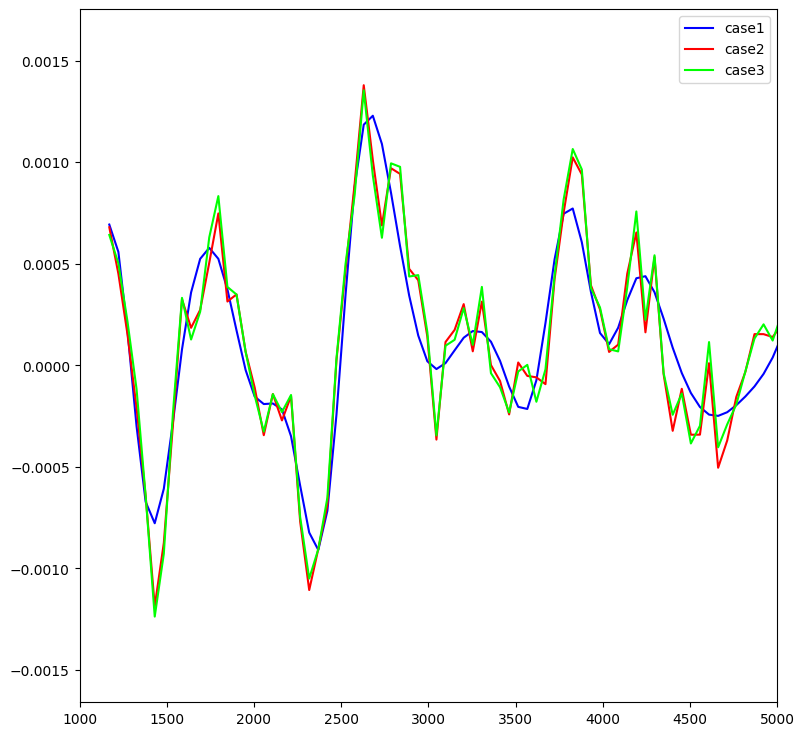

In [22]:
# plot alignment errors for the prev. create three cases
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(9,9)
)

for error_df, color, label in zip(error_dfs, ['blue', 'red', 'lime'], cases.keys()):
    ax.plot(twiss_df.loc[twiss_df.index.str.contains('Q[FD]\d\..*'), 'S'], error_df.DX, color=color, label=label)

ax.legend()
ax.set_xlim([1000,5000])

plt.show()

In [23]:
# create error file to be loaded in madx
error_df = cet.main(
    twiss_df=twiss_df,
    errors_dict={'Reference_radius': 0.01, 'Q[FD]\d\..*':{ 'dX_syst':0.000, },},
    longrangealignment_dict={
        'Q[FD]\d\..*':{
        'X':[
            # [200, 500e-6],
            [50, 200e-6],
            [6, 50e-6],
        ],
        'Y':[
            # [200, 500e-6],
            # [50, 200e-6],
            # [6, 10e-6],
        ],
        },
        },
    seed=1,
    full_table=False,
    outputfile='lra_errors.tfs'
)

In [24]:
# load lattice and errorfile and check twiss
with Madx(stdout=True) as mad:
    mad.input('SET, FORMAT="19.15f";')
    filename = Path(f"./lattices/{OPERATION_MODE}/fccee_{OPERATION_MODE}.seq")
    mad.call(str(filename))
    mad.beam(
                particle='electron',
                npart=214000000000.0,
                kbunch=11200,
                pc=45.6,
                radiate=False,
                bv=1,
                ex=7.1e-10,
                ey=1.9e-12)
    mad.use('FCCEE_P_RING')
    mad.call('install_bpm_orbitcorrectors.madx')
    mad.use('FCCEE_P_RING')
    
    # gotta cycle to a non IP to thread an orbit
    mad.input(
"""SEQEDIT, SEQUENCE = FCCEE_P_RING;
		FLATTEN;
		CYCLE, START=FRF1.1;
		FLATTEN;
ENDEDIT;""")
    mad.use('FCCEE_P_RING')

    mad.input(
"""VOLTCA1SAVE = VOLTCA1; 
VOLTCA2SAVE = VOLTCA2; 

VOLTCA1 = 0;
VOLTCA2 = 0;""")

    mad.twiss(sequence='FCCEE_P_RING', table='noerr')
    mad.input("SAVE, SEQUENCE=FCCEE_P_RING, FILE=test.seq;")

    mad.input("SELECT, FLAG=error, CLEAR;")
    mad.input("READTABLE, file='lra_errors.tfs', table=errtab;")
    mad.input("SETERR, TABLE=errtab;")
    
    mad.input("""
TWISS, BETX=1, BETY=1;
CORRECT, SEQUENCE=FCCEE_P_RING, plane=x, mode=svd, MODEL=noerr, target=noerr, FLAG=line;
CORRECT, SEQUENCE=FCCEE_P_RING, plane=y, mode=svd, MODEL=noerr, target=noerr, FLAG=line;
""")
    
    mad.input("""
TWISS, BETX=1, BETY=1;
CORRECT, SEQUENCE=FCCEE_P_RING, plane=x, mode=svd, MODEL=noerr, target=noerr, FLAG=ring;
CORRECT, SEQUENCE=FCCEE_P_RING, plane=y, mode=svd, MODEL=noerr, target=noerr, FLAG=ring;
""")

    mad.twiss(sequence='FCCEE_P_RING', file=f'twiss_{OPERATION_MODE}_errors.tfs')



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.11.07 16:33:33      +
  ++++++++++++++++++++++++++++++++++++++++++++
!

!SAD2MADX V0.4.1 (11/5/2018)

!Conversion of FCCee_z_572_nosol_1_bb.sad at Sat Jul 22 05:27:22 JST 2023

!

AXISAD =7.274942013244658e-05; BXISAD =.11000142310069985; AYISAD =3.009197112822188e-05; BYISAD =.0007002545795695637; EXISAD =-2.7341457182990933e-05; EPXISAD =-1.6882175221080896e-05; EYISAD =2.648333428031039e-18; EPYISAD =4.880697382588505e-16;

K1QC1R1 = -.28756251406040245;

LQC1R1 = .7;

K1QC1R2 = -.20365990263873562;

LQC1R2 = 1.25;

K1QC1R3 = -.08337134575899513;

LQC1R3 = 1.25;

K1QC2R1 = .1682718887734803;

LQC2R1 = 1.25;

K1QC2R2 = .11914611490034846;

LQC2R2 = 1.25;

K1QC0 = -.027144242097992908;

LQC0 = 2.9;

K1QC3 = -.002648950987045417;

LQC3 = 2.9;

K1QC4 = -.004953882687038241;

L

GC Warning: Repeated allocation of very large block (appr. size 122880):
	May lead to memory leak and poor performance


CORRECTION SUMMARY:   

                   average [mm]   std.dev. [mm]      RMS [mm]        peak-to-peak [mm]

before correction: 0.187113        5.184661          5.188036        48.395078 
after correction:  -0.000231        0.063070          0.063070        1.335571 


Max strength: 1.319576e-01 is below corrector strength limit: 1.000000e+00
Want to correct orbit of a single ring
Want to use target orbit from: noerr
Want to use model orbit from: noerr
1420 monitors and 708 correctors found in input
1420 monitors and 708 correctors enabled

start SVD correction using   708 correctors

CORRECTION SUMMARY:   

                   average [mm]   std.dev. [mm]      RMS [mm]        peak-to-peak [mm]

before correction: 0.000000        0.000000          0.000000        0.000000 
after correction:  0.000000        0.000000          0.000000        0.000000 


Max strength: 0.000000e+00 is below corrector strength limit: 1.000000e+00
enter Twiss module
  
iteration:   1 error:   4.507496E-0

GC Warning: Repeated allocation of very large block (appr. size 110592):
	May lead to memory leak and poor performance


  
iteration:   3 error:   5.497788E-08 deltap:   0.000000E+00
orbit:  -2.070345E-02  3.719405E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
++++++ warning: TWCPIN:  One-turn map R symplectic deviation:  0.128608E-10 (symplectifying R)                                                                                                               

++++++ table: summ

             length              orbit5                alfa             gammatr 
90658.745318756555207  -0.000000000000000   0.000029061386889 185.499110701564916 

                 q1                 dq1             betxmax               dxmax 
218.196112045635260 -119.323963196405131 7733.143840652952349  34.624778142027864 

              dxrms              xcomax              xcorms                  q2 
  3.750734855692762   0.112956750932501   0.011225166080872 222.086601520212895 

                dq2             betymax               dymax               dyrms 
-67.154315064861819 14537.729390282842360  -

In [25]:
twiss_err_df = tfs.read(f'twiss_{OPERATION_MODE}_errors.tfs', index='NAME')

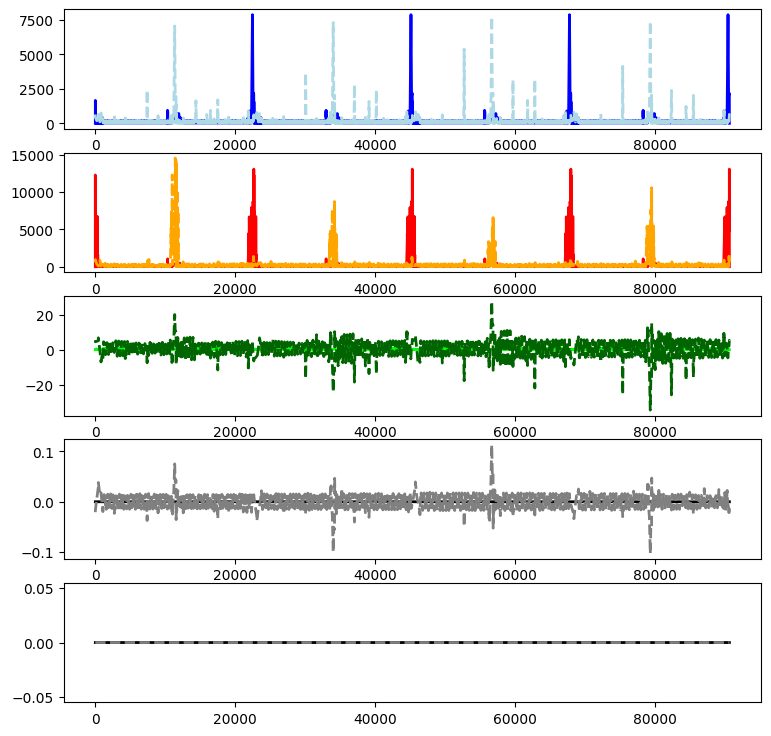

In [26]:
# compare optics between twiss with and without errors
fig, ax = plt.subplots(
    nrows=5,
    ncols=1,
    figsize=(9,9)
)

ax[0].plot(twiss_df.S, twiss_df.BETX, color='blue', linewidth=2)
ax[0].plot(twiss_err_df.S, twiss_err_df.BETX, color='lightblue', linewidth=2, linestyle='--')

ax[1].plot(twiss_df.S, twiss_df.BETY, color='red', linewidth=2)
ax[1].plot(twiss_err_df.S, twiss_err_df.BETY, color='orange', linewidth=2, linestyle='--')

ax[2].plot(twiss_df.S, twiss_df.DX, color='lime', linewidth=2)
ax[2].plot(twiss_err_df.S, twiss_err_df.DX, color='darkgreen', linewidth=2, linestyle='--')

ax[3].plot(twiss_df.S, twiss_df.X, color='black', linewidth=2)
ax[3].plot(twiss_err_df.S, twiss_err_df.X, color='grey', linewidth=2, linestyle='--')

ax[4].plot(twiss_df.S, twiss_df.Y, color='black', linewidth=2)
ax[4].plot(twiss_err_df.S, twiss_err_df.Y, color='grey', linewidth=2, linestyle='--')


plt.show()

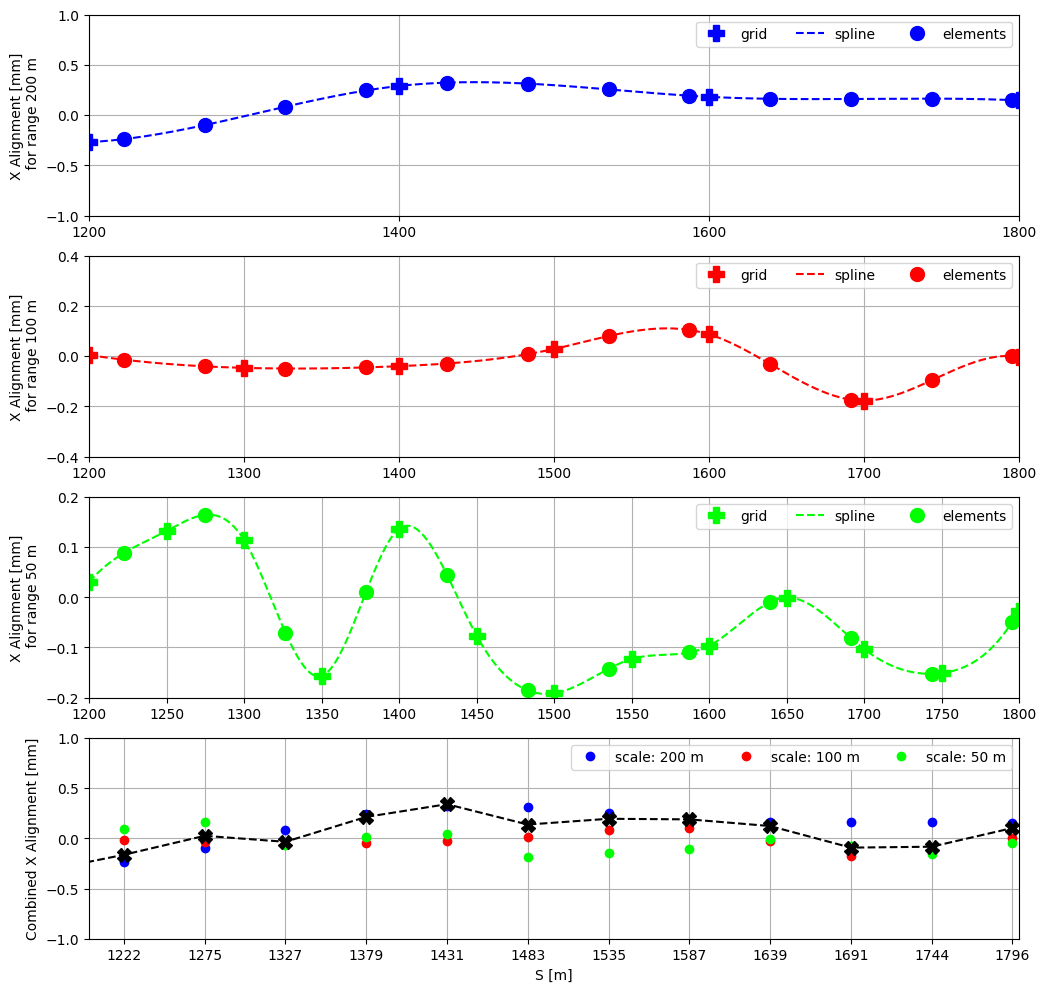

In [27]:
# illustration what happens behind the scenes in the cet.long_range_alignment function

# define a dictionary to illustrate
lra_dict={
    'Q[FD]\d\..*':{
        'X':[
            [200, 500e-6], # for illustration purposes, use similar scale and errors
            [100, 200e-6],
            [50, 100e-6],
        ]
        },
}

# init the random number generator 
random_generator = np.random.default_rng(seed=1)
# for closing the spline, circumference is needed
circumference = twiss_df.iloc[-1]['S']

# define range for plotting
xrange=[1200,1800]
grid_xrange = np.linspace(xrange[0], xrange[1], 1001, endpoint=True)

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, figsize=(12,12))


for key, specs_per_plane in lra_dict.items(): # key refers to the regex command to find elements
    dx = np.zeros_like(twiss_df.loc[twiss_df.index.str.contains(key), 'S']) # array to save combined misalignment
    for plane, alignment in specs_per_plane.items():
        for (scale, tolerance), axis, color in zip(alignment, range(3), ['blue', 'red', 'lime']):
            grid = np.arange(0, circumference, step=scale) # define grid with stepwidth/scale from dictionary
            misalignment = random_generator.normal(loc=0.0, scale=tolerance, size=grid.size) # create array with misalignment for the given grid
            spline = intp.CubicSpline( # create interpolation function with periodic boundary condition to later infer the alignment of the elements between two grid points
                x=np.append(grid, circumference),
                y=np.append(misalignment,misalignment[0]),
                bc_type='periodic',
            )
            # plot + markers at every grid point and the misalignment there
            ax[axis].plot(grid,
                            spline(grid)*1e3,
                            linestyle='None', marker='P', markersize=12, color=color, label='grid')
            # put markers on at grid points
            ax[axis].set_xticks(grid)
            ax[axis].grid(True)
            
            # plot the spline function in the plotting range
            ax[axis].plot(grid_xrange,
                            spline(grid_xrange)*1e3,
                            linestyle='--', color=color, label='spline')
            # plot alignment of alignments in range
            ax[axis].plot(twiss_df.loc[twiss_df.index.str.contains(key), 'S'],
                            spline(twiss_df.loc[twiss_df.index.str.contains(key), 'S'])*1e3,
                            linestyle='None', marker='o', markersize=10, color=color, label='elements')
            
            ax[axis].set_ylabel(f'{plane} Alignment [mm]\n for range {scale} m')
            ax[axis].set_xlim(xrange)
            ax[axis].set_ylim([-2*tolerance*1e3,2*tolerance*1e3])
            ax[axis].legend(ncols=3)

            # add element alignment for different scales to combined plot
            ax[3].plot(twiss_df.loc[twiss_df.index.str.contains(key), 'S'],
                            spline(twiss_df.loc[twiss_df.index.str.contains(key), 'S'])*1e3,
                            linestyle='None', marker='o', markersize=6, color=color, label=f'scale: {scale} m')
            # combine alignment from different scales
            dx += spline(twiss_df.loc[twiss_df.index.str.contains(key), 'S'])

ax[3].set_xticks(twiss_df.loc[twiss_df.index.str.contains('Q[FD]\d\..*'), 'S'])
ax[3].grid(True)
ax[3].set_ylabel(f'Combined {plane} Alignment [mm]')
ax[3].legend(ncols=3)

# plot combined misalignment
ax[3].plot(twiss_df.loc[twiss_df.index.str.contains('Q[FD]\d\..*'), 'S'],
           dx*1e3,
           color='black',linestyle='--', marker='X', markersize=10,)
ax[3].set_xlim(xrange)
ax[3].set_ylim([-0.001*1e3,0.001*1e3])
ax[3].set_xlabel('S [m]')
plt.show()
                